This notebook will record the performance of the UNet that I trained in the previous notebook 'Training a U-net to output bat call maks'. The UNet was trained on the spectrograms of synthetic bat calls and had to output a mask of where the bat call was located in the image. This was all on synthetic data, and it seemed to work pretty well, in terms of capturing the call location ! 

Now however, I want to try two things 
* 1) See how well it does in detecting bat calls taken from ' busy' recordings in the cave
* 2) Figure out how accurate the masks are in terms of acoustic parameters, in terms of FFT magnitudes captured and in terms of the rms values I can recover from the masks. It'd be nice if both of these are satisfactory (within a few dB).

If the two tasks end up showing a nice-ish response then it makes sense that I can actually invest the time and effort required to manually annotate bat calls and spend time understanding the complete logic of the U-Net, or even possibly modify it if necessary. 

In [1]:
import keras 
from keras.models import load_model, model_from_json
import matplotlib.pyplot as plt 
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
import pickle
import scipy.io.wavfile as wav
import scipy.signal as signal 
from skimage.transform import resize




Using TensorFlow backend.


In [2]:
import make_training_data

In [3]:
# thanks https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# load json and create model
json_file = open('batca;;_unet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
unet_model = model_from_json(loaded_model_json)
unet_model.load_weights('model-tgs-salt.h5')

### Testing the model on REAL data from Orlova Chuka :
Fingers crossed, and here it goes. 

In [4]:
def take_snippet(rec, snip_times):
    fs = 192000
    start_ind = int(snip_times['start']*fs)
    end_ind = int(snip_times['end']*fs)
    
    snip_rec = rec[start_ind:end_ind]
    return(snip_rec)

    

In [5]:
fs, rec = wav.read('wavs/Mic01_2018-05-28_03-42-15_1527471735.WAV')


/home/tbeleyur/anaconda2/envs/deeplearning/lib/python2.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [6]:
snip_1 = {'start':5.17}
snip_1['end'] = snip_1['start'] + 0.01

rec_1  = take_snippet(rec, snip_1)


In [7]:
%matplotlib notebook

<IPython.core.display.Javascript object>


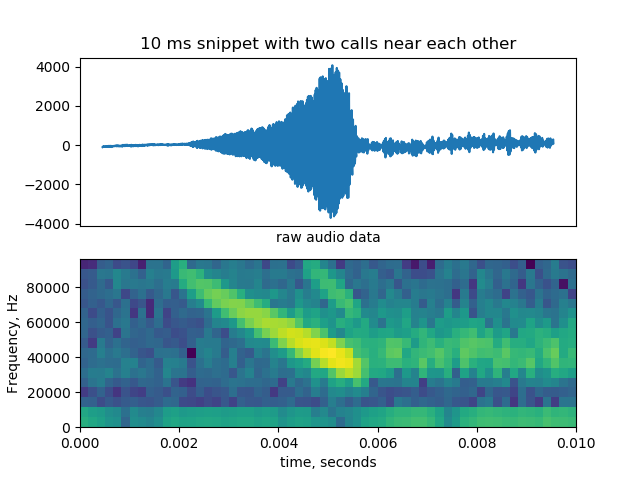

Text(0,0.5,'Frequency, Hz')

In [8]:
plt.figure()
plt.subplot(211)
plt.plot(rec_1);plt.xticks([]);plt.title('10 ms snippet with two calls near each other')
plt.xlabel('raw audio data')
plt.subplot(212)
plt.specgram(rec_1, Fs=192000, NFFT=32, noverlap=0);plt.xlabel('time, seconds');plt.ylabel('Frequency, Hz')

In [9]:
# get the signal.spectrogram output for this snippet, as it's a modified code that doesn't normalise the output spectrogram 
# magnitudes.
f, t, Sxx = signal.spectrogram(rec_1, fs=192000, nperseg=32, noverlap=0, window=('tukey', 0.01),scaling='none')
Sxx = np.flipud(Sxx)
# resize the 17 x 60 matrix to 128 x 128 to make UNet compatible
sxx_resize = resize(Sxx, (128,128), preserve_range=True, mode='constant')
# try to do a band-wise 
sxx_resize_bandmean = make_training_data.mean_subtract_rowwise(sxx_resize)

# make it into a 4D tensor and normalise so that values are between 0 and 1 
sxx_resized = sxx_resize.reshape(1,128,128,1)
sxx_resized = sxx_resized/np.max(sxx_resized)

sxx_resized_bandmean = sxx_resize_bandmean.reshape(1,128,128,1)
sxx_resized_bandmean = sxx_resized_bandmean/np.max(sxx_resize_bandmean)

/home/tbeleyur/anaconda2/envs/deeplearning/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [10]:
# now generate the mask prediction for this call snippet : 
real_call_predn = unet_model.predict(sxx_resized)
real_call_predn_bandmean = unet_model.predict(sxx_resized_bandmean)

<IPython.core.display.Javascript object>


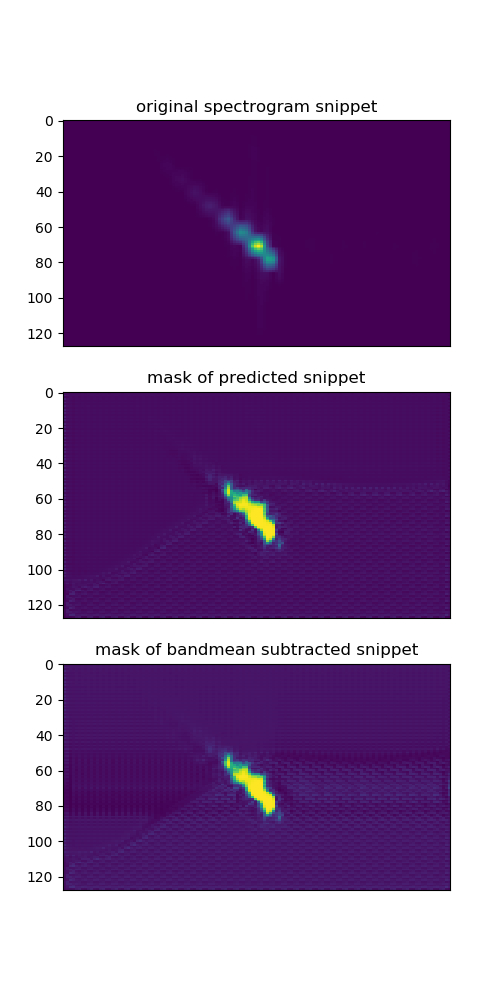

([], <a list of 0 Text xticklabel objects>)

In [11]:
plt.figure(figsize=(5,10))
plt.subplot(311)
plt.title('original spectrogram snippet')
plt.imshow(sxx_resize, aspect='auto'); plt.xticks([])
plt.subplot(312)
plt.title('mask of predicted snippet')
plt.imshow(real_call_predn.reshape(128,128), aspect='auto'); plt.xticks([])
plt.subplot(313)
plt.title('mask of bandmean subtracted snippet')
plt.imshow(real_call_predn_bandmean.reshape(128,128), aspect='auto'); plt.xticks([])


To be sure, let's just plot the 17 x 60 versions of the spectrograms ! 

In [12]:
smaller_predn = resize(real_call_predn.reshape(128,128), (17,60), anti_aliasing=True)

/home/tbeleyur/anaconda2/envs/deeplearning/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<IPython.core.display.Javascript object>


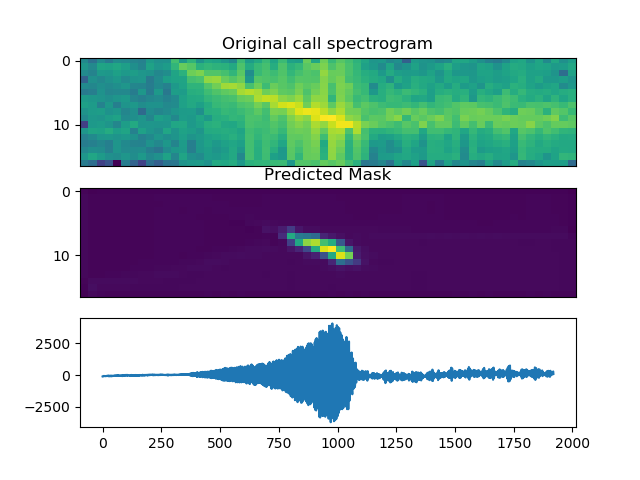

In [13]:
plt.figure()
plt.subplot(311)
plt.imshow(20*np.log10(Sxx), aspect='auto') ; plt.xticks([]);plt.title('Original call spectrogram')
plt.subplot(312)
plt.imshow(smaller_predn, aspect='auto') ; plt.xticks([]);plt.title('Predicted Mask')
plt.subplot(313)
plt.plot(rec_1)



## Question 1 
### Can the current UNet manage to segment out bat calls? :
### .......kind of !

The current UNet was trained on rather 'clean' synthetic data with white noise, no reverberation, no tightly placed calls, or the other whole suite of complications that exist in real audio data. Butttt - it can still segment out the relevant parts of the bat call - even though it tends to make a single bat call into multiple blobs !! 

What I realised after a lot of playing around is:

* 1) keep the *same* spectrogram parameters: window type, window extent etc
* 2) it is very important to feed the network *normalised* input images otherwise it will spout out rather weird values
* 3) the network is trained on synthetic calls that mimic 'on-axis' calls, and so is not able to cope with calls that have a gradual lowpass (fading intensity as the frequency gets higher) - as they may be from further away or also off-axis. 


### .....and it does pick up what it was trained to do with the synthetic data after all...
As proof of principle let's see how it does on the test data set that it had never seen, neither in the training or indirectly in the validation. 

In [14]:
# load the original test data: 
test_data = open('sound_spec_mask/test_data.pkl','rb')
test = pickle.load(test_data)

In [15]:
# load the model predictions on the test data:
pred_test = open('sound_spec_mask/predicted_test_masks.pkl', 'rb')
pred = pickle.load(pred_test)
pred_resize = pred.reshape(-1,128,128)

In [16]:
# downsample the model predictions from 128x128 to 17x60
specs_downsampl = np.zeros((pred_resize.shape[0],17,60))
for i in range(pred_resize.shape[0]):
    specs_downsampl[i,:,:] = resize(pred_resize[i,:,:],output_shape=(17,60),preserve_range=True, anti_aliasing=True) 

In [17]:
pred_resize.shape, specs_downsampl.shape

((200, 128, 128), (200, 17, 60))

<IPython.core.display.Javascript object>


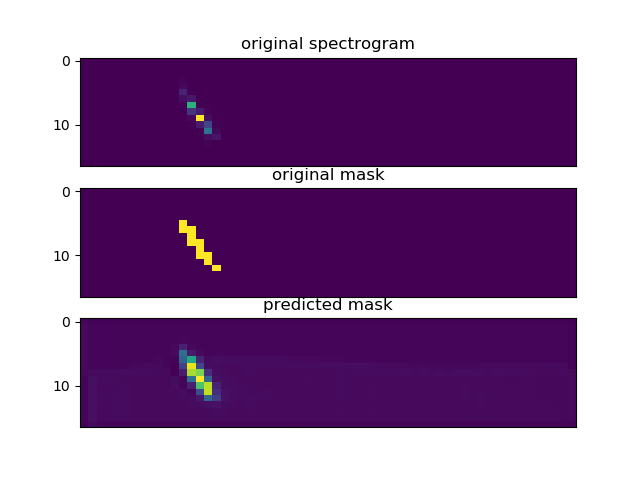

([], <a list of 0 Text xticklabel objects>)

In [18]:
rand_ind = int(np.random.choice(np.arange(0,199),1))
first_uid = test.keys()[rand_ind]

plt.figure()
plt.subplot(311)
plt.title('original spectrogram')
plt.imshow(test[first_uid]['specgm'], aspect='auto');plt.xticks([])
plt.subplot(312)
plt.title('original mask')
plt.imshow(test[first_uid]['mask_specgm'], aspect='auto');plt.xticks([])
plt.subplot(313)
plt.title('predicted mask')
plt.imshow(specs_downsampl[rand_ind,:,:], aspect='auto');plt.xticks([])

### Do the output masks produce acoustically reliable outputs when used ? 
I'm going to use the output masks to take out those spectrogram 'pixels' and then calculate the following parameters:
* 1) rms 
* 2) call duration
* 3) frequency range 

Let's start with the one that's more controlled - the synthetic data.

<IPython.core.display.Javascript object>


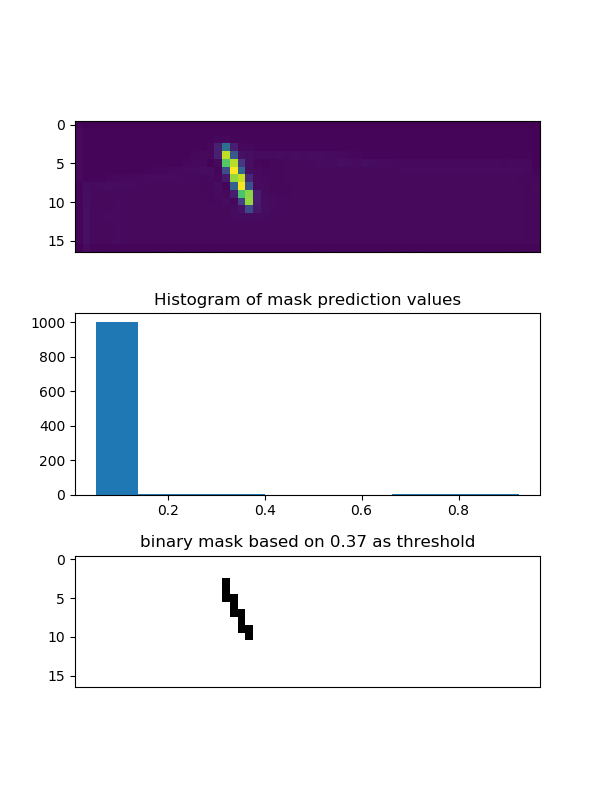

([], <a list of 0 Text xticklabel objects>)

In [19]:
# set threshold to get the masks - mainly by trial and error :
rand_ind = np.random.choice(np.arange(specs_downsampl.shape[0]))
chosen_mask = specs_downsampl[rand_ind,:,:]
threshold = np.percentile(chosen_mask.flatten(), 99)

binary_mask = np.zeros(chosen_mask.shape)
binary_mask[chosen_mask>=threshold] = 1 

plt.figure(figsize=(6,8))
plt.subplot(311)
plt.imshow(chosen_mask);plt.xticks([])
plt.subplot(312)
plt.title('Histogram of mask prediction values')
plt.hist(chosen_mask.flatten())
plt.subplot(313)
plt.title('binary mask based on ' + str(np.round(threshold,2)) +' as threshold')
plt.imshow(binary_mask, cmap='Greys');plt.xticks([])

From trial and error, it seems like choosing the 99th percentil of prediction values allows me to get a clear cut binary mask of the synthetic call. Now let's use this to extract out the required data.

In [65]:
def extract_calls_from_prediction(prediction_mask, specgram):
    ''' Extract out a vertical segment of the original spectrogram 
    that contains all frequency bands, but is cropped on the time axis. 
    '''
    threshold = np.percentile(prediction_mask.flatten(), 99)
    binary_mask = np.zeros(prediction_mask.shape)
    binary_mask[prediction_mask>=threshold] = 1 
    
    # get the columns that the call occupies and segment out that section. 
    cols_w_ones = np.apply_along_axis(lambda X : np.sum(X), 0, binary_mask)
    start_col, end_col  = np.min(np.argwhere(cols_w_ones>=1)), np.max(np.argwhere(cols_w_ones>=1))
    # the chosen call area from the spectrogram
    chosen_area = specgram[:, start_col:end_col]
            
    return(chosen_area, start_col, end_col)



<IPython.core.display.Javascript object>


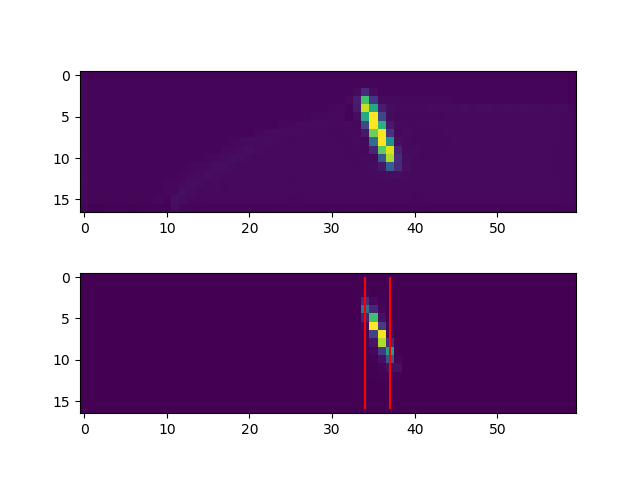

<IPython.core.display.Javascript object>


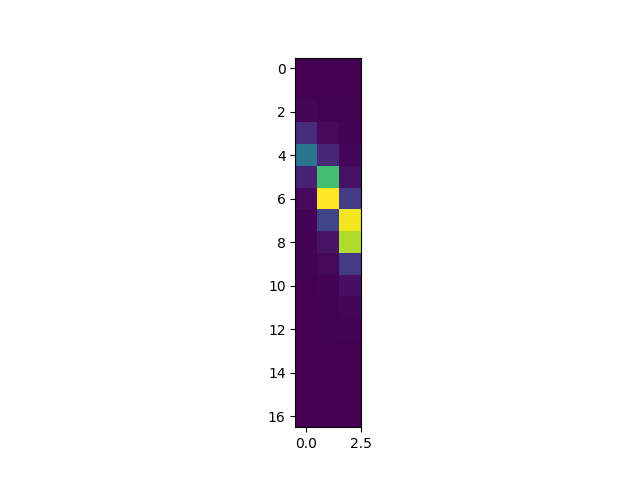

In [69]:
rand_ind = int(np.random.choice(np.arange(0,199),1))
first_uid = test.keys()[rand_ind]
segment, start, end = extract_calls_from_prediction(specs_downsampl[rand_ind], test[first_uid]['specgm'])
plt.figure()
plt.subplot(211)
plt.imshow(specs_downsampl[rand_ind])
plt.subplot(212)
plt.imshow(test[first_uid]['specgm'])
plt.vlines(start,0,16,'r')
plt.vlines(end,0,16,'r')

plt.figure()
plt.imshow(segment)

In [80]:
import scipy.misc
scipy.misc.imsave('outfile_real.png', Sxx)

/home/tbeleyur/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


In [82]:
96000/64

1500